In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.cluster import KMeans
import string

In [2]:
#chemin absolu vers le répertoire contenant les données (à modifier avant d'exécuter le code)

path = '/home/.../content/NIST_simple.npy'

In [3]:
#chargement des données dans des arrays distincts pour entraînement/test, variables/cible

with open(path, 'rb') as file :
    train_images = np.load(file)
    train_labels = np.load(file)
    test_images = np.load(file)
    test_labels = np.load(file)

In [4]:
#normalisation des coefficients entre 0 et 1

train_images, test_images = train_images/255.0, test_images/255.0

## 1 - Réseaux de neurones sur NIST_simple

### A) Construction des modèles

In [5]:
#restructuration des données pour le réseau de neurones convolutif (on précise qu'on travaille en nuances de gris et non en RGB)

cnn_train_images = train_images.reshape(train_images.shape[0], train_images.shape[1], train_images.shape[2],
1)
cnn_test_images = test_images.reshape(test_images.shape[0], test_images.shape[1], test_images.shape[2],
1)

In [6]:
#définition structurelle du perceptron multicouche

mlp_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(26, activation='softmax')
])

In [6]:
#définition structurelle du réseau de neurones convolutif

cnn_model = keras.Sequential([
    keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D((3, 3)), #2,2 avant
    keras.layers.Conv2D(64, (2, 2), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(26, activation='softmax')
])

In [7]:
#définition de la métrique de précision multiclasse avec scikit-learn (puisque Keras ne la prend pas en charge au stade de l'entraînement)

def precision(y_true, y_pred):
    y_true = y_true.numpy()
    y_pred = y_pred.numpy()
    y_pred = y_pred.argmax(axis=1)
    return precision_score(y_true, y_pred, average='macro', zero_division=1)

In [9]:
#compilation du perceptron multicouche

mlp_model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[precision],
                  run_eagerly=True)

In [8]:
#compilation du réseau de neurones convolutif

cnn_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[precision],
                 run_eagerly=True)

In [11]:
#entraînement du perceptron multicouche

mlp_history = mlp_model.fit(train_images, train_labels, epochs=10, validation_split = 0.2, shuffle=True)

Epoch 1/10
1625/1625 [==============================] - 74s 44ms/step - loss: 2.7281 - precision: 0.7371 - val_loss: 1.4415 - val_precision: 0.6703
Epoch 2/10
1625/1625 [==============================] - 70s 43ms/step - loss: 1.2857 - precision: 0.6960 - val_loss: 0.9538 - val_precision: 0.7646
Epoch 3/10
1625/1625 [==============================] - 69s 42ms/step - loss: 0.9698 - precision: 0.7643 - val_loss: 0.9064 - val_precision: 0.7831
Epoch 4/10
1625/1625 [==============================] - 68s 42ms/step - loss: 0.8312 - precision: 0.7901 - val_loss: 0.7815 - val_precision: 0.7995
Epoch 5/10
1625/1625 [==============================] - 69s 42ms/step - loss: 0.7271 - precision: 0.8124 - val_loss: 0.6297 - val_precision: 0.8388
Epoch 6/10
1625/1625 [==============================] - 74s 45ms/step - loss: 0.6442 - precision: 0.8291 - val_loss: 0.5836 - val_precision: 0.8461
Epoch 7/10
1625/1625 [==============================] - 70s 43ms/step - loss: 0.5936 - precision: 0.8413 - val_l

In [9]:
#entraînement du réseau de neurones convolutif

cnn_history = cnn_model.fit(cnn_train_images, train_labels, epochs=5, validation_split = 0.2, shuffle=True)

Epoch 1/5
1625/1625 [==============================] - 134s 80ms/step - loss: 1.4152 - precision: 0.8428 - val_loss: 0.2780 - val_precision: 0.9260
Epoch 2/5
1625/1625 [==============================] - 129s 80ms/step - loss: 0.2406 - precision: 0.9336 - val_loss: 0.2097 - val_precision: 0.9411
Epoch 3/5
1625/1625 [==============================] - 126s 78ms/step - loss: 0.1856 - precision: 0.9486 - val_loss: 0.2094 - val_precision: 0.9415
Epoch 4/5
1625/1625 [==============================] - 126s 78ms/step - loss: 0.1488 - precision: 0.9586 - val_loss: 0.1672 - val_precision: 0.9555
Epoch 5/5
1625/1625 [==============================] - 127s 78ms/step - loss: 0.1335 - precision: 0.9628 - val_loss: 0.1696 - val_precision: 0.9539


### B) Évaluation des modèles

In [21]:
#calcul de la prédiction pour les données de test avec le perceptron multicouche

mlp_pred_labels = mlp_model.predict(test_images)
mlp_pred_labels_cat = mlp_pred_labels.argmax(axis=1)

In [14]:
#calcul de la prédiction pour les données de test avec le réseau de neurones convolutif

cnn_pred_labels = cnn_model.predict(cnn_test_images)
cnn_pred_labels_cat = cnn_pred_labels.argmax(axis=1)

In [23]:
#vectorisation de la cible

flat_test_labels = test_labels.flatten()

In [16]:
#définition d'une fonction retournant sous forme de liste l'index des prédictions erronées en comparant les prédictions avec la vérité terrain

def wrong_predictions(true_labels, predicted_labels):
    wp = [] #mauvaises prédictions
    for i in range(len(predicted_labels)):
        if predicted_labels[i] != true_labels[i]:
            wp.append(i)
    return wp

In [24]:
#création d'une liste contenant l'index des prédictions erronées pour chaque modèle

mlp_wp = wrong_predictions(flat_test_labels, mlp_pred_labels_cat)
cnn_wp = wrong_predictions(flat_test_labels, cnn_pred_labels_cat)

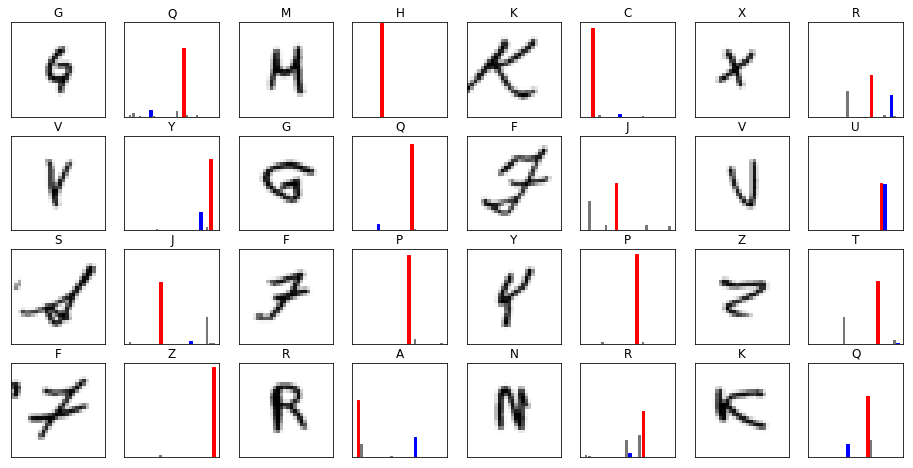

In [25]:
#examen de 16 mauvaises prédictions issues du perceptron multicouche

#pour chaque mauvaise prédiction, l'image mal étiquetée (à gauche) et l'histogramme des probabilités calculées (à droite)
#au-dessus de chaque lettre : sa vraie étiquette
#au-dessus de chaque histogramme : l'étiquette prédite erronée (représentée sur l'histogramme par la barre rouge, par opposition à la barre bleue qui désigne la vraie étiquette)

plt.figure(figsize=(16,8))
for i in range(16):
    #affichage de la lettre
    plt.subplot(4,8,2*i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_images[mlp_wp[i]], cmap='gray')
    plt.title(list(string.ascii_uppercase)[flat_test_labels[mlp_wp[i]]])
    #affichage de l'histogramme
    plt.subplot(4,8,2*(i+1))
    barplot = plt.bar(range(26), mlp_pred_labels[mlp_wp[i]], color="#777777")
    plt.ylim([0,1])
    plt.xticks([])
    plt.yticks([])
    barplot[mlp_pred_labels_cat[mlp_wp[i]]].set_color('red')
    barplot[flat_test_labels[mlp_wp[i]]].set_color('blue')
    plt.title(list(string.ascii_uppercase)[mlp_pred_labels_cat[mlp_wp[i]]])

Les mauvaises prédictions réalisées par le perceptron multicouche concernent en premier lieu des lettres formées de manière ambiguë : le S et le F de la première colonne, le F de la deuxième colonne, le V de la quatrième colonne... 

On comprend que certains éléments de graphie puissent induire en erreur le modèle : la "queue" du G de la première colonne peut faire penser à un Q, qui est la sortie prédite par le modèle ; la forme inclinée du F de la troisième colonne, exception faite de la barre horizontale, peut effectivement suggérer un J ; l'incurvation du M de la deuxième colonne peut être prise pour une barre horizontale de H.

D'autres erreurs sont plus difficilement explicables : un oeil humain ne pourrait prendre le X de la quatrième colonne pour un R, de même que le R de la deuxième colonne se distingue clairement d'un A.

Dans certains cas, le modèle pose avec quasi-certitude une prédiction erronée (lorsque la barre rouge associée avoisine une probabilité de 1), mais dans d'autres cas on observe un flottement : le modèle "hésite" entre plusieurs lettres, parmi lesquelles on retrouve souvent la véritable lettre écrite (représentée par la barre bleue), qui n'est parfois même rejetée qu'à quelques centièmes près (par exemple dans le cas du dilemme U/V de la quatrième colonne.

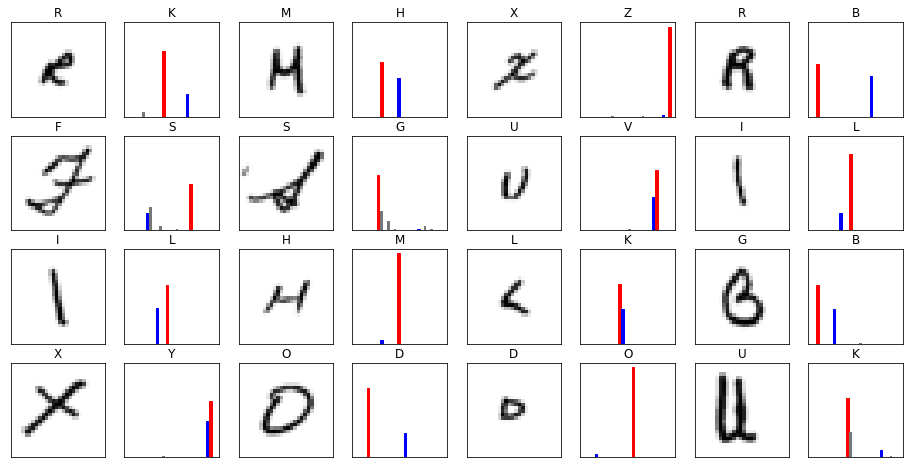

In [25]:
#examen de 16 mauvaises prédictions issues du réseau de neurones convolutif

plt.figure(figsize=(16,8))
for i in range(16):
    plt.subplot(4,8,2*i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_images[cnn_wp[i]], cmap='gray')
    plt.title(list(string.ascii_uppercase)[flat_test_labels[cnn_wp[i]]])
    plt.subplot(4,8,2*(i+1))
    barplot = plt.bar(range(26), cnn_pred_labels[cnn_wp[i]], color="#777777")
    plt.ylim([0,1])
    plt.xticks([])
    plt.yticks([])
    barplot[cnn_pred_labels_cat[cnn_wp[i]]].set_color('red')
    barplot[flat_test_labels[cnn_wp[i]]].set_color('blue')
    plt.title(list(string.ascii_uppercase)[cnn_pred_labels_cat[cnn_wp[i]]])

On observe le même phénomène pour les prédictions erronées du réseau de neurones convolutif : certaines lettres capitales sont manifestement mal formées (le G de la quatrième colonne, le X de la troisième colonne...), tandis que d'autres sont mal étiquetées sans raison apparente (les deux I, ou le R de la dernière colonne). On relève d'ailleurs certaines erreurs communes aux deux modèles (le F de la première colonne, le S de la deuxième).

On remarque cependant que la vraie catégorie est plus souvent "envisagée" par le modèle que dans le cas du perceptron multicouche, puisque la barre bleue indique une probabilité substantielle dans 14 erreurs sur 16, contre 10 sur 16 pour le perceptron multicouche, ce qui suggère que le réseau de neurones convolutif s'approche davantage de la vérité terrain (même lorsqu'il commet des erreurs).

In [28]:
#matrice de confusion pour les données de test pour le perceptron multicouche

cm = confusion_matrix(test_labels, mlp_pred_labels_cat)
pd.options.display.max_columns = 26
pd.DataFrame(cm, index=list(string.ascii_uppercase), columns=list(string.ascii_uppercase))

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z
A,460,7,0,3,0,0,3,19,0,0,7,3,6,0,1,0,0,20,0,0,0,0,0,3,0,1
B,9,455,0,17,1,0,2,5,0,0,4,0,3,0,6,2,3,12,1,0,0,0,0,3,0,3
C,1,2,771,0,2,0,2,0,6,1,2,31,0,2,4,3,0,7,1,1,0,0,0,0,0,8
D,1,4,3,467,0,0,0,0,0,1,0,1,2,0,21,3,2,2,1,1,3,1,1,0,1,5
E,1,10,11,0,311,4,10,0,2,0,13,6,1,0,2,0,1,12,1,0,0,0,0,1,0,6
F,6,4,2,3,11,430,4,2,4,2,4,1,3,0,0,53,0,5,3,8,0,2,0,0,3,3
G,4,15,4,4,9,0,369,1,0,0,0,4,1,1,4,0,31,1,12,0,2,0,0,1,0,1
H,3,5,0,1,0,0,2,375,0,0,9,1,7,6,0,0,0,5,0,0,6,0,3,1,0,1
I,2,0,6,4,0,3,0,0,1680,57,7,26,0,0,0,0,0,0,8,7,0,1,0,41,3,145
J,0,1,0,6,1,0,2,1,16,394,0,3,0,0,0,0,0,3,11,7,3,0,0,1,0,9


In [19]:
#matrice de confusion pour les données de test pour le réseau de neurones convolutif

cm = confusion_matrix(test_labels, cnn_pred_labels_cat)
pd.options.display.max_columns = 26
pd.DataFrame(cm, index=list(string.ascii_uppercase), columns=list(string.ascii_uppercase))

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z
A,507,1,1,0,0,1,0,5,1,0,5,4,1,0,0,3,1,3,0,0,0,0,0,0,0,0
B,1,503,0,1,0,0,8,1,0,2,1,0,0,0,4,2,0,1,2,0,0,0,0,0,0,0
C,0,0,821,0,5,0,5,0,0,3,2,2,0,0,2,2,1,0,0,0,1,0,0,0,0,0
D,1,2,1,440,0,0,0,1,1,15,0,0,1,0,53,5,0,0,0,0,0,0,0,0,0,0
E,0,1,2,0,378,4,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,3
F,0,1,1,0,1,544,2,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,1
G,0,3,1,0,0,2,447,2,0,0,1,0,0,0,3,0,2,0,3,0,0,0,0,0,0,0
H,3,0,0,0,0,1,0,405,0,0,2,2,3,5,0,1,0,0,0,0,3,0,0,0,0,0
I,0,0,7,3,4,9,0,0,1799,103,0,36,0,0,0,0,0,0,2,4,0,8,0,1,1,13
J,0,0,0,0,0,1,1,0,1,451,0,0,0,0,1,0,0,0,0,1,0,2,0,0,0,0


On constate, en comparant les deux matrices de confusion, que les coefficients présents sur la diagonale sont généralement de plus forte valeur dans le cas du réseau de neurones convolutif, ce qui signifie que ce modèle obtient des meilleures performances de catégorisation pour quasiment toutes les lettres.

On s'aperçoit aussi que les erreurs "compréhensibles" (nous désignons par là celles qu'un humain pourrait faire aussi) sont communes aux deux modèles : confusions I/J, O/D... En revanche, certaines erreurs moins "compréhensibles" deviennent plus rares avec le réseau de neurones convolutif : confusions X/K, I/Z, R/K...

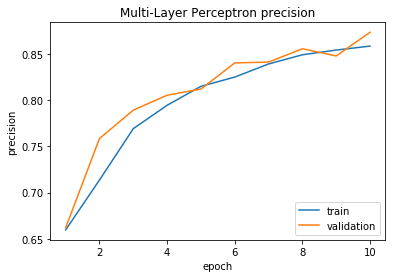

In [16]:
#Graphique précision/époch pour les données d'entraînement et de test avec le perceptron multicouche 

plt.plot(np.arange(1,11), mlp_history.history['precision'])
plt.plot(np.arange(1,11), mlp_history.history['val_precision'])
plt.title('Multi-Layer Perceptron precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

Comme espéré, la précision augmente sur l'échantillon réservé à la validation au fil des epochs, dépassant les 85%. Les deux courbes ont un tracé très proche, indiquant que le perceptron multicouche n'est pas en overfitting, et la grande amplitude entre les valeurs extrêmes (près de 0.2) signale que le modèle s'améliore considérablement au cours de son entraînement.

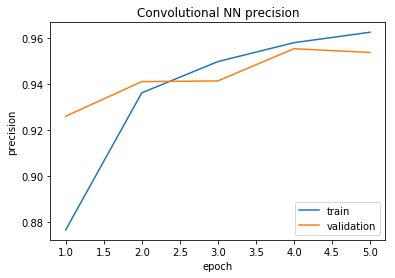

In [13]:
#Graphique précision/époch pour les données d'entraînement et de test avec le réseau de neurones convolutif

plt.plot(np.arange(1,6), cnn_history.history['precision'])
plt.plot(np.arange(1,6), cnn_history.history['val_precision'])
plt.title('Convolutional NN precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

Les courbes pour le réseau de neurones convolutif sont moins entrelacées ; la précision est moins bonne pour les données d'entraînement que pour les données de validation au début de l'entraînement, suggérant un léger underfitting à ce stade. On observe le phénomène contraire à partir de la troisième epoch, et le score décroît pour les données de validation entre la quatrième et la cinquième epoch, suggérant alors un léger overfitting (puisqu'il continue d'augmenter sur les données d'entraînement).

Notons que la faible amplitude entre les valeurs extrêmes (à peine plus de 0.8) tend à relativiser ces constats : le modèle est très performant d'entrée et apprend aussi très rapidement par la suite, requérant de ce fait moins de passages successifs sur l'ensemble du dataset d'entraînement.

## 2 - Forêt aléatoire sur NIST_simple

In [6]:
#restructuration des données pour l'entraînement de la forêt aléatoire

rfc_train_images = train_images.reshape(train_images.shape[0], train_images.shape[1]*train_images.shape[2])
rfc_train_labels = train_labels.ravel()
rfc_test_images = test_images.reshape(test_images.shape[0], test_images.shape[1]*test_images.shape[2])
rfc_test_labels = test_labels.ravel()

In [7]:
#création et entraînement de la forêt aléatoire

rfc_model = RandomForestClassifier(random_state=0)
rfc_model.fit(rfc_train_images, rfc_train_labels)

RandomForestClassifier(random_state=0)

In [8]:
#calcul de la prédiction pour les données de test avec la forêt aléatoire

rfc_pred_labels = rfc_model.predict(rfc_test_images)

In [9]:
#évaluation de la performance de la forêt aléatoire avec le score de cross-validation

cv_results = cross_validate(rfc_model, rfc_train_images, rfc_train_labels, cv=5, scoring='precision_macro')
cv_results['test_score'].mean()

0.9015252491545496

In [10]:
cm = confusion_matrix(rfc_test_labels, rfc_pred_labels)
pd.options.display.max_columns = 26
pd.DataFrame(cm, index=list(string.ascii_uppercase), columns=list(string.ascii_uppercase))

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z
A,495,2,0,1,0,1,5,7,0,0,4,2,9,1,0,0,2,1,0,1,0,0,1,1,0,0
B,6,492,0,7,1,1,2,1,0,0,1,0,1,0,2,1,3,4,3,0,0,0,0,0,1,0
C,0,1,799,0,4,0,2,0,2,0,1,14,0,0,12,4,2,1,0,1,1,0,0,0,0,0
D,1,3,2,453,0,0,1,0,2,2,0,0,1,0,44,5,2,0,1,2,0,0,0,0,0,1
E,0,4,5,0,347,10,11,0,1,0,2,1,1,0,3,1,0,3,0,0,0,0,1,0,0,2
F,0,2,1,0,2,508,3,0,3,2,0,0,0,0,0,22,0,0,3,6,0,0,0,0,1,0
G,2,12,3,0,3,7,407,0,0,1,0,1,0,0,4,0,21,0,3,0,0,0,0,0,0,0
H,6,4,0,1,0,0,1,381,0,0,3,0,11,4,0,0,0,2,0,0,6,2,1,1,0,2
I,0,0,7,3,2,5,1,0,1825,54,1,12,0,0,1,0,0,0,4,18,0,1,0,3,1,52
J,1,2,0,2,0,0,1,0,10,419,0,0,0,1,3,0,0,0,10,6,1,2,0,0,0,0


On constate que le score de cross-validation est bon, avec une moyenne d'environ 0.9 entre les cinq folds différents, ce qui indique que la forêt aléatoire n'est pas en overfitting.

A l'examen de la matrice de confusion résultante sur les données de test (et notamment des coefficients présents sur la diagonale), on peut estimer les performances de ce modèle comme intermédiaires entre le perceptron multicouche et le réseau de neurones convolutif. On y retrouve le même type d'erreurs qu'avec nos deux réseaux de neurones.

## 3 - Approche non supervisée sur un échantillon aléatoire de NIST_simple

In [11]:
#tirage aléatoire de 400 images provenant de NIST_simple

data_train = np.concatenate((train_images.reshape(train_images.shape[0], 784), train_labels), axis=1)
data_test = np.concatenate((test_images.reshape(test_images.shape[0], 784), test_labels), axis=1)
data = np.concatenate((data_train, data_test), axis=0)

random_indices = np.random.choice(data.shape[0], 400)

data = data[random_indices,:]
cats = data[:, 784].astype('int')
data = data[:,:784].reshape(400, train_images.shape[1], train_images.shape[2], 1)

In [27]:
#reprise des couches convolutives du second réseau de neurones pour extraire les composantes caractéristiques

feature_extractor = tf.keras.Model(cnn_model.inputs, cnn_model.layers[-4].output)

In [70]:
#transformation des données avec les couches convolutives et restructuration pour le modèle non-supervisé

new_data = feature_extractor.predict(data)
new_data = new_data.reshape(new_data.shape[0], new_data.shape[1]*new_data.shape[2]*new_data.shape[3])

In [71]:
#création et entraînement de l'algorithme K-moyennes

km_model = KMeans(n_clusters=26, random_state=0)
km_model.fit(new_data)

KMeans(n_clusters=26, random_state=0)

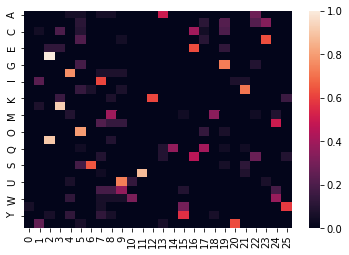

In [72]:
#carte de chaleur visant à évaluer l'homogénéité des différentes catégories d'images

conf_like = np.zeros((26,26))
for i in range(new_data.shape[0]):
    conf_like[cats[i],km_model.labels_[i]] += 1
conf_like = conf_like/conf_like.sum(axis=1, keepdims=True)
conf_like_df = pd.DataFrame(conf_like, index=list(string.ascii_uppercase))
sns.heatmap(conf_like_df)

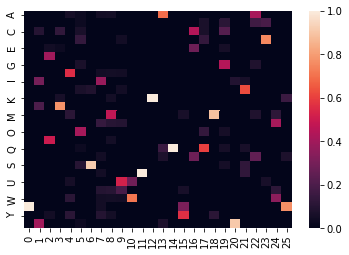

In [73]:
#carte de chaleur visant à évaluer l'homogénéité des différents clusters

conf_like = np.zeros((26,26))
for i in range(new_data.shape[0]):
    conf_like[cats[i],km_model.labels_[i]] += 1
conf_like = conf_like/conf_like.sum(axis=0, keepdims=True)
conf_like_df = pd.DataFrame(conf_like, index=list(string.ascii_uppercase))
sns.heatmap(conf_like_df)

La configuration idéale serait que l'on obtienne deux cartes de chaleur identiques, avec une unique case blanche par colonne et par ligne : chacun des 26 clusters formés correspondrait à une lettre de l'alphabet. Ce n'est malheureusement pas le cas.

On constate sur la première carte que de nombreuses lettres sont réparties entre différents clusters (de nombreuses lignes comportent plusieurs valeurs supérieures à 0), toutefois quelques lettres semblent plus concentrées dans des clusters précis : F, L, P ou encore T.

On constate sur la seconde carte que de nombreux clusters contiennent des lettres différentes (de nombreuses colonnes comportent plusieurs valeurs supérieures à 0), toutefois certains clusters semblent être plus homogènes : les clusters 0, 6, 11, 12, 14, 18 ou encore 20.

In [79]:
#définition d'une fonction retournant sous forme de liste l'index des images correspondant à une lettre donnée

def clust_letter(n):
    cl = []
    for i in range(data.shape[0]):
        if cats[i] == n :
            cl.append(i)
    return cl

In [74]:
#définition d'une fonction retournant sous forme de liste l'index des images incluses à un cluster donné par le modèle

def img_cluster(n):
    ic = []
    for i in range(len(km_model.labels_)):
        if km_model.labels_[i] == n:
            ic.append(i)
    return ic

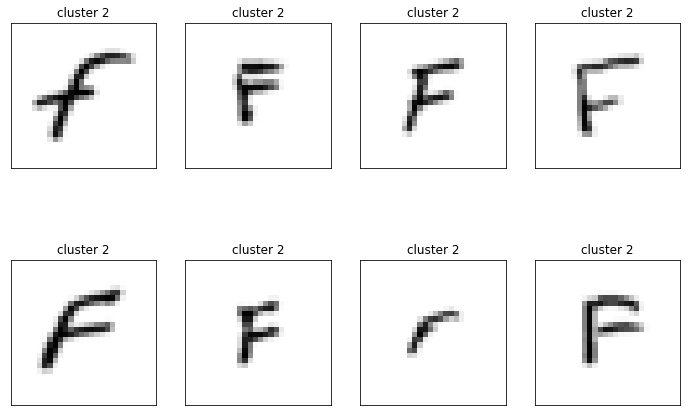

In [82]:
#examen du cluster attribué à 8 images de la lettre F

plt.figure(figsize=(12,8))
for i in range(8):
    plt.subplot(2,4, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(data[clust_letter(5)[i]].reshape((28,28)), cmap='gray')
    plt.title('cluster ' + str(km_model.labels_[clust_letter(5)[i]]))

Les huit premières images représentant la lettre F sont effectivement toutes regroupées dans un même cluster : le cluster 2.

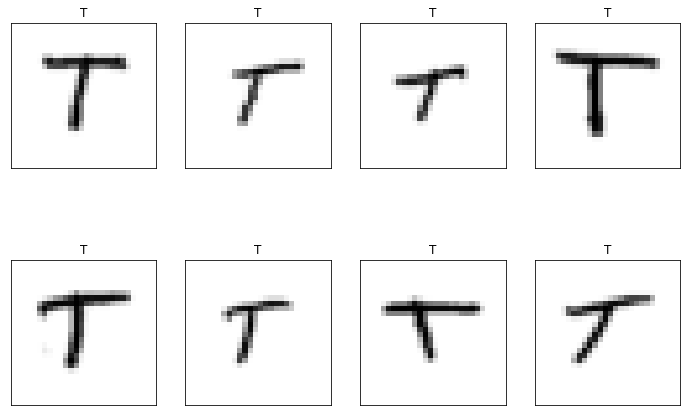

In [75]:
#examen de 8 images associées au cluster 11 par le modèle

plt.figure(figsize=(12,8))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(data[img_cluster(11)[i]].reshape((28,28)), cmap='gray')
    plt.title(list(string.ascii_uppercase)[cats[img_cluster(11)[i]]])

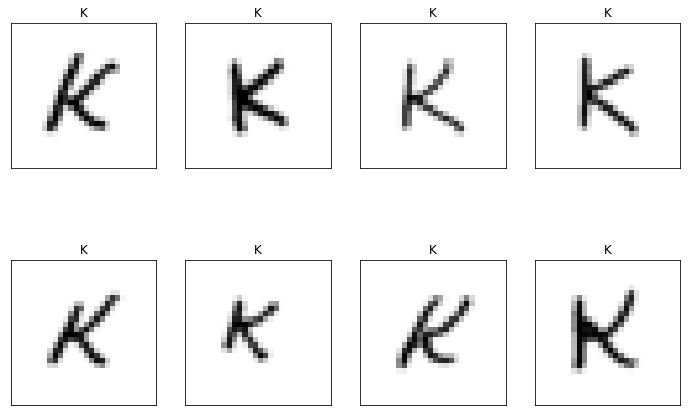

In [76]:
#examen de 8 images associées au cluster 12 par le modèle

plt.figure(figsize=(12,8))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(data[img_cluster(12)[i]].reshape((28,28)), cmap='gray')
    plt.title(list(string.ascii_uppercase)[cats[img_cluster(12)[i]]])

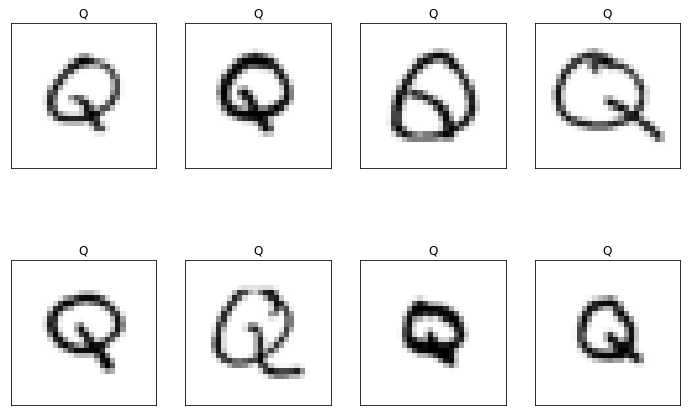

In [77]:
#examen de 8 images associées au cluster 14 par le modèle

plt.figure(figsize=(12,8))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(data[img_cluster(14)[i]].reshape((28,28)), cmap='gray')
    plt.title(list(string.ascii_uppercase)[cats[img_cluster(14)[i]]])

Les huit premières images du cluster 11 (respectivement 12, 14) représentent effectivement toutes la même lettre : la lettre T (respectivement K, Q).

En conclusion, la classification non-supervisée des images de lettres capitales manuscrites s'avère logiquement moins performante que les différentes méthodes de classification supervisées que nous avons implémentées plus haut, mais parvient tout de même à produire une correspondance cohérente, dans une fraction non-négligeable des cas, entre catégories et clusters.